In [44]:
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

In [45]:
import pandas as pd
import pandas_datareader.data as web

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

In [46]:
# Fix the path construction - use forward slashes or raw strings
import os

# Method 1: Use forward slashes (recommended)
path = os.path.abspath(os.path.join("..", "04_S&P500_quant_analysis", "01_data", "S&P500_D_1789-05-01_2025-09-17.csv"))

# Alternative Method 2: Use raw string
# path = os.path.abspath(os.path.join("..", r"04_S&P500_quant_analysis\01_data", "S&P500_D_1789-05-01_2025-09-17.csv"))

# Alternative Method 3: Use pathlib (modern approach)
# from pathlib import Path
# path = Path("..") / "04_S&P500_quant_analysis" / "01_data" / "S&P500_D_1789-05-01_2025-09-17.csv"

# print(f"Path exists: {os.path.exists(path)}")

# Read the CSV file
df = pd.read_csv(path)

# lower case column names for easier access
df.columns = [col.lower() for col in df.columns]

# Set the 'date' column as the index and convert it to datetime
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Show the first few rows of the dataframe
df.head()

,open,high,low,close,volume
date,,,,,
1789-05-01,0.51,0.51,0.51,0.51,0.0
1789-06-01,0.51,0.51,0.51,0.51,0.0
1789-07-01,0.50,0.50,0.50,0.50,0.0
1789-08-01,0.50,0.51,0.50,0.51,0.0
1789-09-01,0.51,0.51,0.50,0.51,0.0


In [47]:
# Calculate simple returns with pct_change()
df['simple_returns'] = df['close'].pct_change()

# Drop NA values that result from pct_change()
df.dropna(inplace=True)

# Show dataframe
df.head()

,open,high,low,close,volume,simple_returns
date,,,,,,
1789-06-01,0.51,0.51,0.51,0.51,0.0,0.000000
1789-07-01,0.50,0.50,0.50,0.50,0.0,-0.019608
1789-08-01,0.50,0.51,0.50,0.51,0.0,0.020000
1789-09-01,0.51,0.51,0.50,0.51,0.0,0.000000
1789-10-01,0.51,0.51,0.51,0.51,0.0,0.000000


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39531 entries, 1789-06-01 to 2025-09-17
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            39531 non-null  float64
 1   high            39531 non-null  float64
 2   low             39531 non-null  float64
 3   close           39531 non-null  float64
 4   volume          39531 non-null  float64
 5   simple_returns  39531 non-null  float64
dtypes: float64(6)
memory usage: 2.1 MB


In [49]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

In [50]:
# Load monthly industrial production and daily S&P 500 stock market index:
year_start = '1988'
year_sp500 = year_start 

# Fix: Use proper datetime operations instead of integer subtraction
year_month_end = df.index.max().strftime('%Y-%m')
year_month_day_end = df.index.max().strftime('%Y-%m-%d')

industrial_production = web.DataReader('IPGMFN', 'fred', year_start, year_month_end).squeeze().dropna()

# sp500 = web.DataReader('SP500', 'fred', year_sp500, year_month_day_end).squeeze().dropna()
sp500 = df.copy().loc[year_sp500:year_month_day_end]['close']

In [51]:
industrial_production.head()

DATE
1988-01-01    55.6315
1988-02-01    56.8324
1988-03-01    57.5487
1988-04-01    57.7727
1988-05-01    57.8687
Name: IPGMFN, dtype: float64

In [52]:
sp500.head()

date
1988-01-04    255.94
1988-01-05    258.63
1988-01-06    258.89
1988-01-07    261.07
1988-01-08    243.40
Name: close, dtype: float64

In [53]:
industrial_production.tail()

DATE
2025-04-01    101.1476
2025-05-01    100.9192
2025-06-01    102.2925
2025-07-01     99.4847
2025-08-01    101.7890
Name: IPGMFN, dtype: float64

In [54]:
sp500.tail()

date
2025-09-11    6587.47
2025-09-12    6584.29
2025-09-15    6615.28
2025-09-16    6606.76
2025-09-17    6600.35
Name: close, dtype: float64

In [55]:
components = tsa.seasonal_decompose(industrial_production, model='additive')

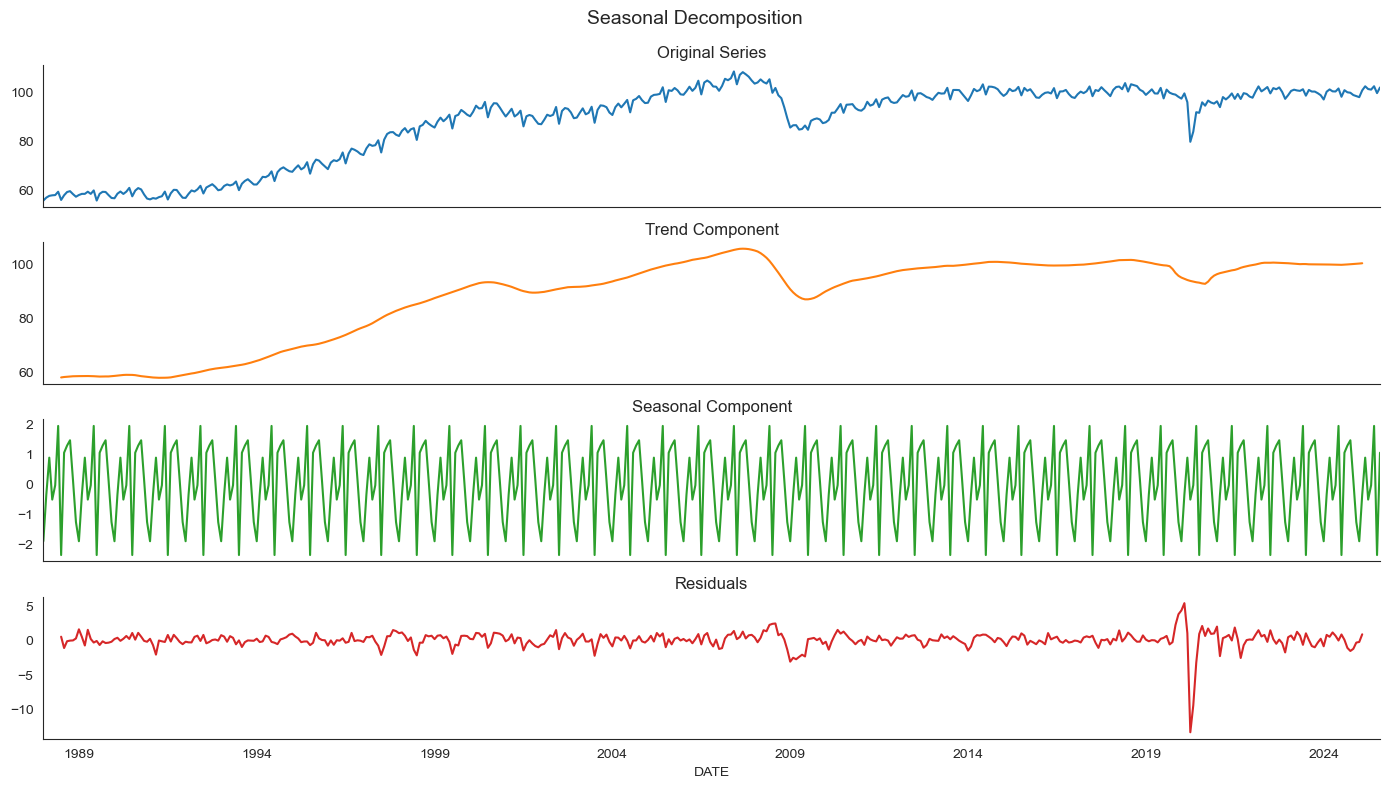

In [56]:
ts = (industrial_production.to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

In [57]:
# Double check for zero values
(industrial_production==0).any(), (sp500==0).any()

(False, False)

In [58]:
# Log Transformation
industrial_production_log = np.log(industrial_production)
sp500_log = np.log(sp500)

In [59]:
industrial_production_log.head()

DATE
1988-01-01    4.018750
1988-02-01    4.040107
1988-03-01    4.052632
1988-04-01    4.056516
1988-05-01    4.058177
Name: IPGMFN, dtype: float64

In [60]:
sp500_log.head()

date
1988-01-04    5.544943
1988-01-05    5.555398
1988-01-06    5.556403
1988-01-07    5.564789
1988-01-08    5.494706
Name: close, dtype: float64

In [61]:
"""
Differencing
In many cases, de-trending is not sufficient to make the series stationary. 
Instead, we need to transform the original data into a series of period-to-period 
and/or season-to-season differences. 
In other words, we use the result of subtracting neighboring data points 
or values at seasonal lags from each other. 
Note that when such differencing is applied to a log-transformed series, 
the results represent instantaneous growth rates or returns in a financial context.

If a univariate series becomes stationary after differencing d times, 
it is said to be integrated of the order of d, or simply integrated if d=1. 
This behavior is due to so-called unit roots.

Differencing of log series produces instantaneous returns.
""";

In [62]:
# Differencing
# seasonal differencing => yoy instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()
sp500_log_diff = sp500_log.diff(12).dropna()

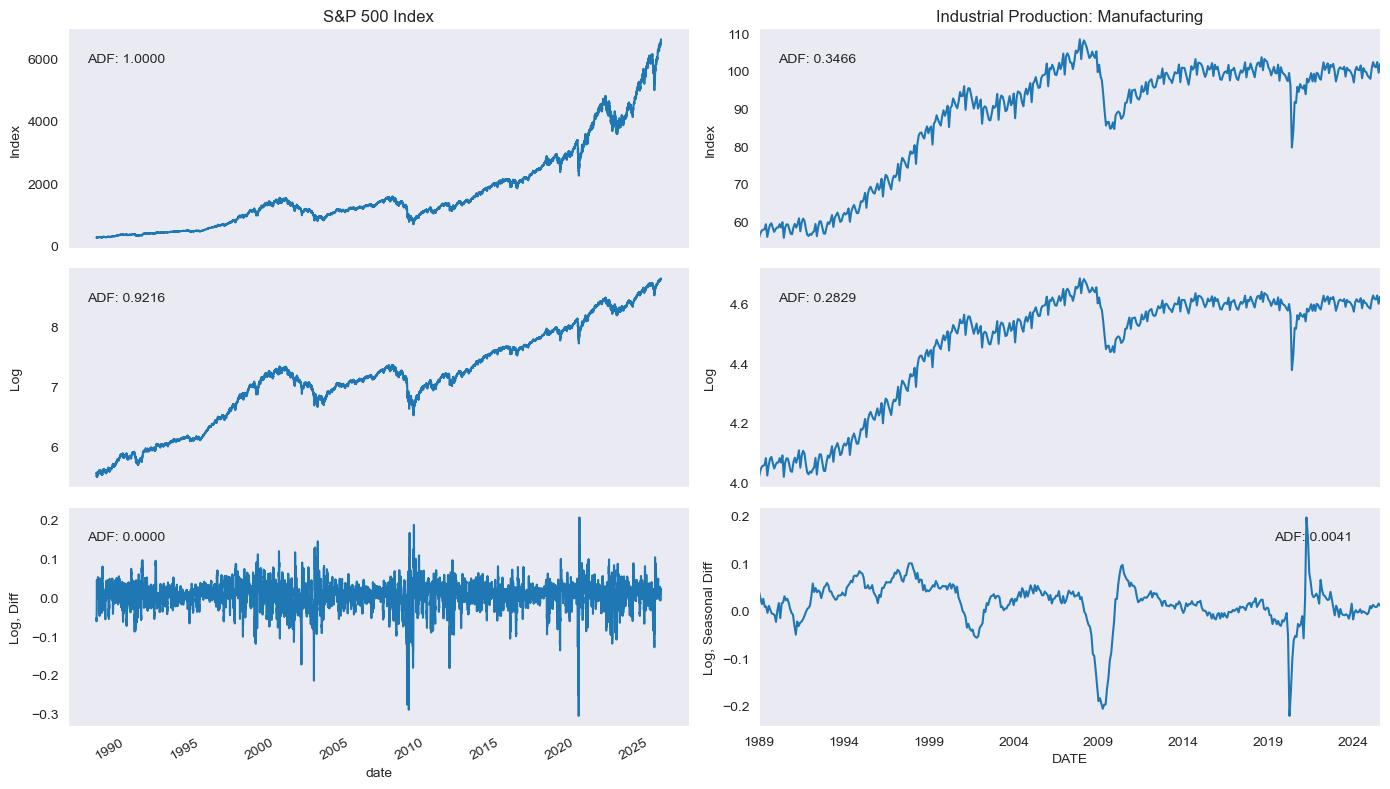

In [63]:
with sns.axes_style('dark'):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))

    sp500.plot(ax=axes[0][0],
                title='S&P 500 Index')
    axes[0][0].text(x=.03,
                    y=.85,
                    s=f'ADF: {tsa.adfuller(sp500.dropna())[1]:.4f}',
                    transform=axes[0][0].transAxes)
    axes[0][0].set_ylabel('Index')

    sp500_log.plot(ax=axes[1][0],
                    sharex=axes[0][0])
    axes[1][0].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(sp500_log.dropna())[1]:.4f}',
                    transform=axes[1][0].transAxes)
    axes[1][0].set_ylabel('Log')

    sp500_log_diff.plot(ax=axes[2][0],
                         sharex=axes[0][0])
    axes[2][0].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(sp500_log_diff.dropna())[1]:.4f}',
                    transform=axes[2][0].transAxes)
    axes[2][0].set_ylabel('Log, Diff')

    industrial_production.plot(ax=axes[0][1],
                               title='Industrial Production: Manufacturing')
    axes[0][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production)[1]:.4f}',
                    transform=axes[0][1].transAxes)
    axes[0][1].set_ylabel('Index')

    industrial_production_log.plot(ax=axes[1][1],
                                   sharex=axes[0][1])
    axes[1][1].text(x=.03, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_log.dropna())[1]:.4f}',
                    transform=axes[1][1].transAxes)
    axes[1][1].set_ylabel('Log')

    industrial_production_log_diff.plot(ax=axes[2][1],
                                        sharex=axes[0][1])
    axes[2][1].text(x=.83, y=.85,
                    s=f'ADF: {tsa.adfuller(industrial_production_log_diff.dropna())[1]:.4f}',
                    transform=axes[2][1].transAxes)
    axes[2][1].set_ylabel('Log, Seasonal Diff')
    sns.despine()
    fig.tight_layout()
    fig.align_ylabels(axes)

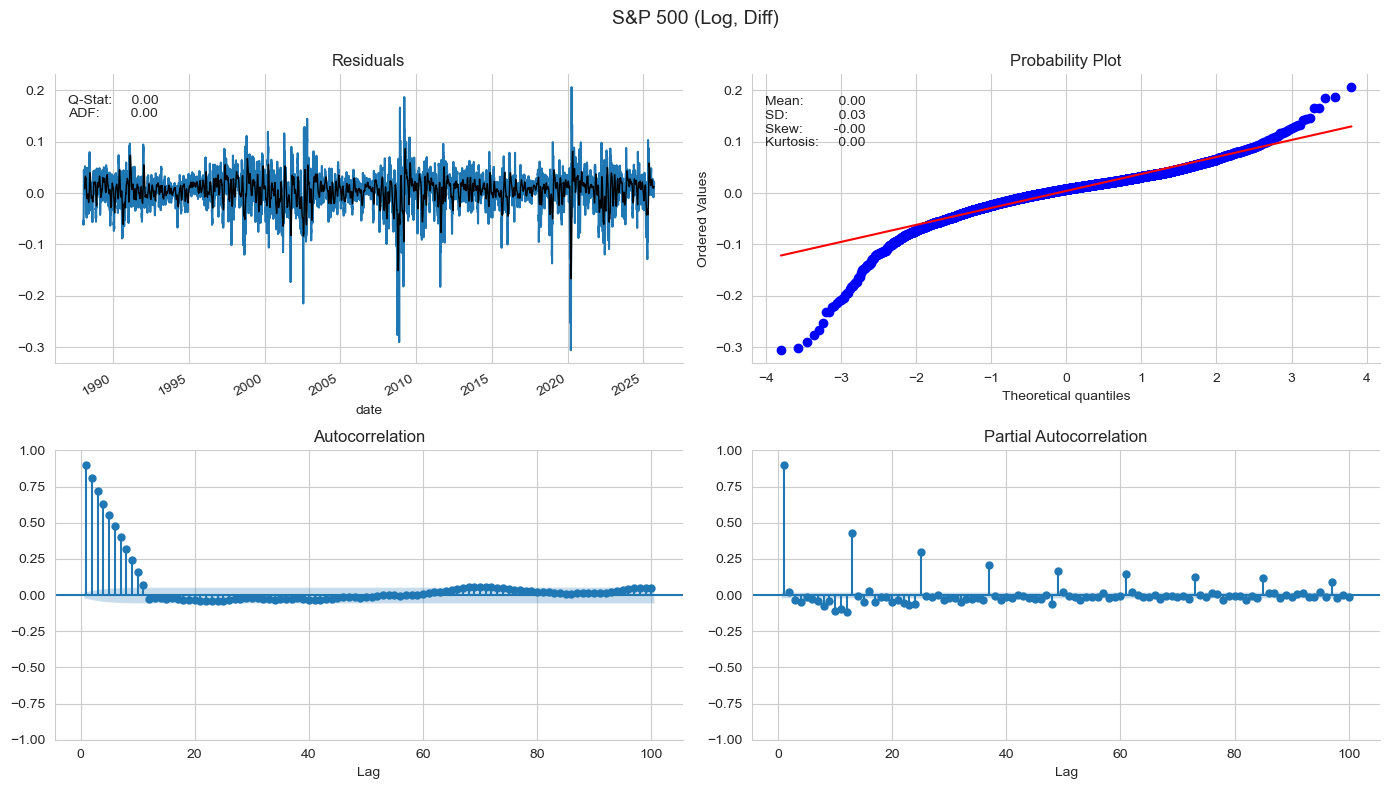

In [64]:
plot_correlogram(sp500_log_diff, lags=100, title='S&P 500 (Log, Diff)')